<a href="https://colab.research.google.com/github/Hebaallah61/AI_Project_objectdetection/blob/main/cnnimageonly2_CNN_PAD_UFES_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical 

from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = os.path.join('..', '/content/drive/MyDrive/PAD-UFES-20')

# Merging images from the 3 folders into one dictionary

img_id_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_dir, '*', '*.png'))}

lesion_type_dict = {
    'BCC': 'Basal Cell Carcinoma',
    'ACK': 'Actinic Keratosis',
    'NEV': 'Nevus',
    'SEK': 'Seborrheic Keratosis',
    'SCC': 'Squamous Cell Carcinoma',
    'MEL': 'Melanoma'
}

In [ ]:
skin_df = pd.read_csv(os.path.join(base_dir, '/content/drive/MyDrive/PAD-UFES-20/metadata.csv'))

# Creating New Columns for better readability

#print (img_id_path_dict)
skin_df['img_id'] = skin_df['img_id'].str.replace(r'.png$', '') 
#print(skin_df['img_id'])
skin_df['path'] = skin_df['img_id'].map(img_id_path_dict.get)
#print(skin_df['path'])

skin_df['cell_type'] = skin_df['diagnostic'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes
skin_df=skin_df.drop(skin_df.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]],axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
# Now lets see the sample of tile_df to look on newly made columns
skin_df.head()

,path,cell_type,cell_type_idx
0,/content/drive/MyDrive/PAD-UFES-20/PAD-UFES-20...,Nevus,3
1,/content/drive/MyDrive/PAD-UFES-20/PAD-UFES-20...,Basal Cell Carcinoma,1
2,/content/drive/MyDrive/PAD-UFES-20/PAD-UFES-20...,Actinic Keratosis,0
3,/content/drive/MyDrive/PAD-UFES-20/PAD-UFES-20...,Actinic Keratosis,0
4,/content/drive/MyDrive/PAD-UFES-20/PAD-UFES-20...,Basal Cell Carcinoma,1


In [ ]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).convert('RGB').resize((100,75),Image.ANTIALIAS)))

In [ ]:
print(skin_df['image'])

0       [[[152, 107, 65], [151, 105, 63], [153, 106, 6...
1       [[[173, 141, 136], [176, 146, 142], [174, 144,...
2       [[[219, 158, 155], [219, 159, 156], [223, 171,...
3       [[[198, 191, 193], [201, 198, 199], [201, 197,...
4       [[[129, 101, 90], [130, 101, 90], [135, 108, 9...
                              ...                        
2293    [[[137, 77, 58], [138, 79, 59], [140, 82, 62],...
2294    [[[187, 175, 173], [187, 175, 175], [187, 173,...
2295    [[[195, 172, 157], [189, 165, 149], [210, 190,...
2296    [[[151, 110, 102], [150, 110, 99], [148, 106, ...
2297    [[[191, 175, 168], [186, 162, 151], [190, 169,...
Name: image, Length: 2298, dtype: object


In [ ]:
skin_df.head()

,path,cell_type,cell_type_idx,image
0,/content/drive/MyDrive/PAD-UFES-20/PAD-UFES-20...,Nevus,3,"[[[152, 107, 65], [151, 105, 63], [153, 106, 6..."
1,/content/drive/MyDrive/PAD-UFES-20/PAD-UFES-20...,Basal Cell Carcinoma,1,"[[[173, 141, 136], [176, 146, 142], [174, 144,..."
2,/content/drive/MyDrive/PAD-UFES-20/PAD-UFES-20...,Actinic Keratosis,0,"[[[219, 158, 155], [219, 159, 156], [223, 171,..."
3,/content/drive/MyDrive/PAD-UFES-20/PAD-UFES-20...,Actinic Keratosis,0,"[[[198, 191, 193], [201, 198, 199], [201, 197,..."
4,/content/drive/MyDrive/PAD-UFES-20/PAD-UFES-20...,Basal Cell Carcinoma,1,"[[[129, 101, 90], [130, 101, 90], [135, 108, 9..."


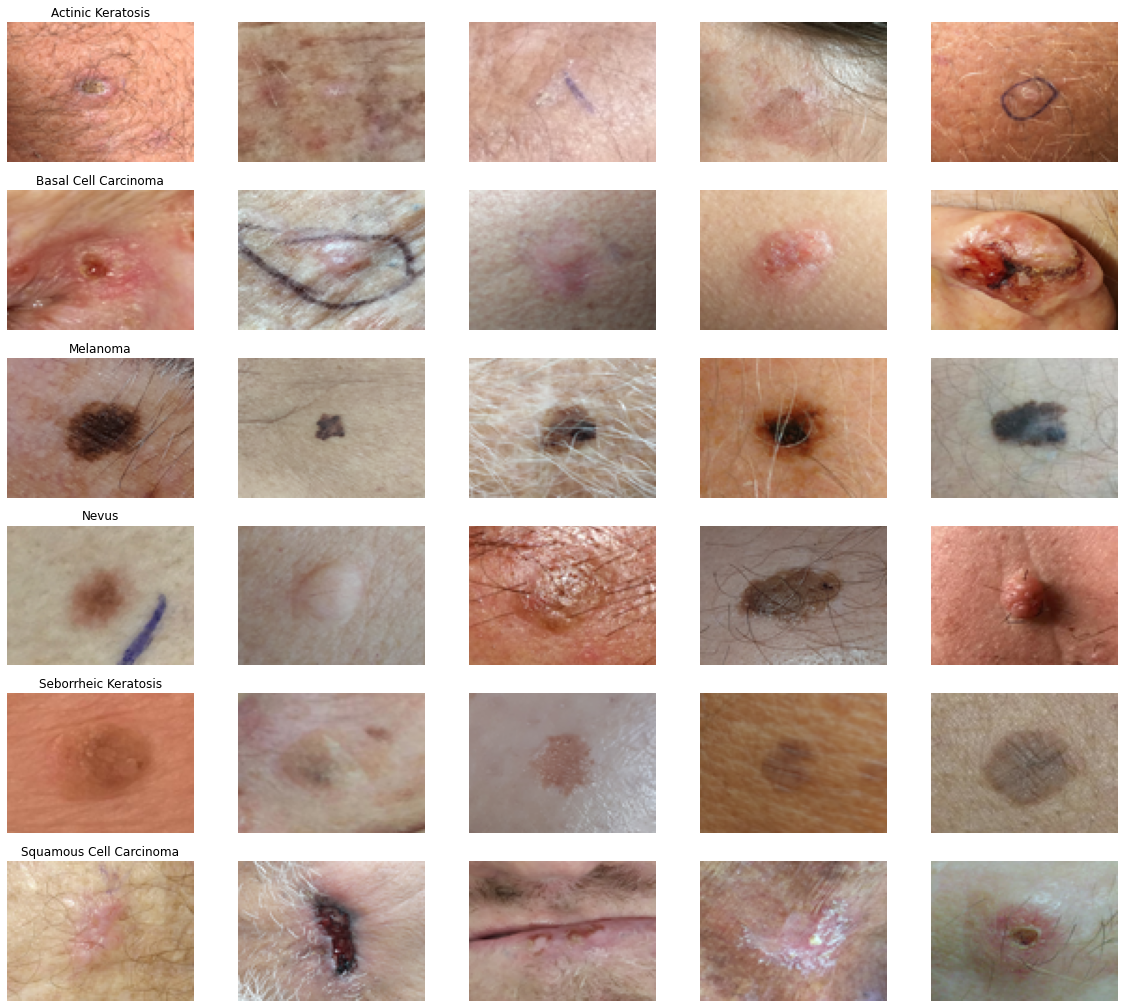

In [ ]:
n_samples = 5
fig, m_axs = plt.subplots(6, n_samples, figsize = (4*n_samples, 3*6))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [ ]:
# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    2298
Name: image, dtype: int64

In [ ]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [ ]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, 
                                                            target, 
                                                            test_size=0.20,
                                                            random_state=1234)

In [ ]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [ ]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 6)
y_test = to_categorical(y_test_o, num_classes = 6)

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [ ]:
# Reshape image in 3 dimensions (height = 120px, width = 160px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [ ]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (75, 100, 3)
num_classes = 6

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25)) 

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 100, 32)       896       
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 100, 32)       9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 50, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 37, 50, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 50, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 50, 64)        36928     
                                                        

In [ ]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [ ]:
# Fit the model
epochs = 50 
batch_size = 16
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, 
                              validation_data = (x_validate,y_validate),
                              verbose = 1, 
                              steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/50
103/103 [==============================] - 15s 58ms/step - loss: 1.6286 - accuracy: 0.3553 - val_loss: 1.4225 - val_accuracy: 0.4130 - lr: 0.0010
Epoch 2/50
103/103 [==============================] - 5s 48ms/step - loss: 1.4862 - accuracy: 0.3907 - val_loss: 1.2790 - val_accuracy: 0.5054 - lr: 0.0010
Epoch 3/50
103/103 [==============================] - 5s 48ms/step - loss: 1.4020 - accuracy: 0.4481 - val_loss: 1.3696 - val_accuracy: 0.4348 - lr: 0.0010
Epoch 4/50
103/103 [==============================] - 5s 48ms/step - loss: 1.3761 - accuracy: 0.4799 - val_loss: 1.2158 - val_accuracy: 0.5707 - lr: 0.0010
Epoch 5/50
103/103 [==============================] - 5s 48ms/step - loss: 1.3388 - accuracy: 0.4860 - val_loss: 1.2692 - val_accuracy: 0.5543 - lr: 0.0010
Epoch 6/50
103/103 [==============================] - 5s 48ms/step - loss: 1.2708 - accuracy: 0.5067 - val_loss: 1.1723 - val_accuracy: 0.6196 - lr: 0.0010
Epoch 7/50
103/103 [==============================] - 5s 48ms/s

In [ ]:
#Model Evaluation
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

6/6 [==============================] - 0s 17ms/step - loss: 1.2460 - accuracy: 0.5815
Validation: accuracy = 0.581522  ;  loss_v = 1.245982
Test: accuracy = 0.604348  ;  loss = 1.308092


In [ ]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


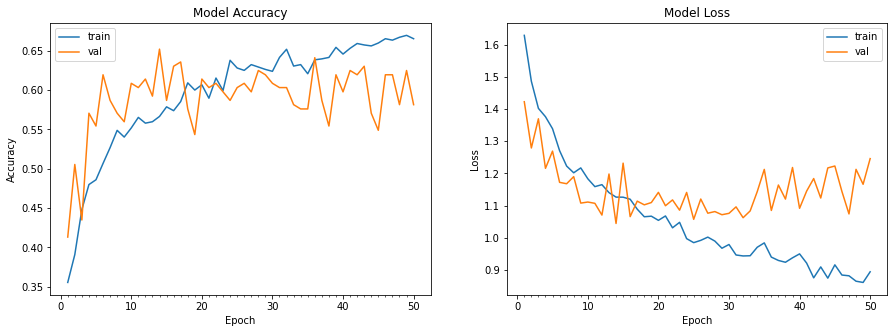

In [ ]:
plot_model_history(history)

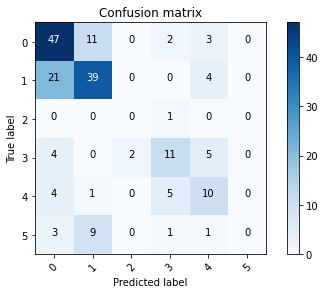

In [ ]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(6))

Text(0, 0.5, 'Fraction classified incorrectly')

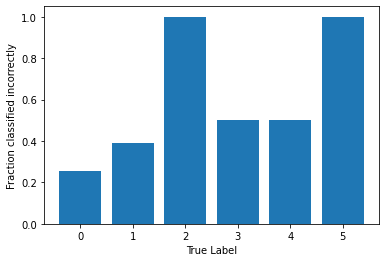

In [ ]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(6),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')